# Working with geodatabase (shapefiles and rasters) and map plots of raster statistics

In [627]:
%matplotlib inline
from __future__ import print_function, division
import seaborn as sns
sns.set(rc={'image.cmap': 'cubehelix'})
sns.set_context('poster')

import pandas as pd
import os
import glob
import pip
import netCDF4, numpy
import numpy as np
np.random.seed(0)
from numpy import linspace, meshgrid

# GIS modules
import geopandas as gp
import folium
import postgis
import imageio
from osgeo import gdal
import rasterstats
import fiona
import vincent
vincent.core.initialize_notebook()


"""
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr""" 

# Plotting functions
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.patches import PathPatch
from matplotlib.colors import rgb2hex, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors
from matplotlib.mlab import griddata


import geopandas
from rasterio import features
from affine import Affine
import xarray as xray

import sys
sys.path.insert(0,'..')

# Geodatabase (geopandas)

In [3]:
# Open the Counties shape file and inspect the contents
counties_file = "/home2/svimal/Github/CA_drought/data/Spatial/CA_counties/CA_counties.shp"
counties_gp = gp.GeoDataFrame.from_file(counties_file)
counties_gp.head(2)
print(counties_gp.columns)
lts = []
lns = []
for i in range(len(counties_gp["INTPTLAT"])):
    lts.append(float(counties_gp["INTPTLAT"][i]))
    lns.append(float(counties_gp["INTPTLON"][i]))
    #len(counties_gp["INTPTLON"]))
print(lts[0:5], lns[0:5])

Index([     u'ALAND',     u'AWATER',     u'CBSAFP',    u'CLASSFP',
         u'COUNTYFP',   u'COUNTYNS',      u'CSAFP',   u'FUNCSTAT',
            u'GEOID',   u'INTPTLAT',   u'INTPTLON',       u'LSAD',
         u'METDIVFP',      u'MTFCC',       u'NAME',   u'NAMELSAD',
         u'OBJECTID',    u'STATEFP', u'Shape_Area', u'Shape_Leng',
        u'geoid_num',   u'geometry'],
      dtype='object')
[39.5769252, 38.4500114, 34.5370572, 38.1838996, 34.3587415] [-120.5219926, -121.3404409, -120.0399729, -120.5614415, -119.1331432]


# NetCDF data

In [404]:
# The NetCDF I/O files from VIC model archive
filenames = glob.glob("/home2/svimal/Data/VIC_Fluxes/*/*")
fname = filenames[0]
print(fname)
data = netCDF4.Dataset(fname, "r")
#print(data.variables)

# Also Xarray library can be used. Use Xarray preferably.

/home2/svimal/Data/VIC_Fluxes/1950s/fluxes.1953-04.nc


In [392]:
# Inspect the variables inside data
print("Time, Lat, Lon, Soil_liquid")
print(len(data["time"][:]), len(data["lat"][:]), len(data["lon"][:]),  len(data["Soil_liquid"][:]))
data["lat"][0:5], data["lon"][0:5] # subset of lat lon data

Time, Lat, Lon, Soil_liquid
30 350 310 30


(array([ 31.15625,  31.21875,  31.28125,  31.34375,  31.40625]),
 array([-124.84375, -124.78125, -124.71875, -124.65625, -124.59375]))

In [383]:
# data.variables["Soil_liquid"][29][2][349][309] # #data.variables["Soil_liquid"][time][lat][lon]
data_lists = []
for soil_layer in [0]:#,1,2]:
    for time in range(len(data["time"][:])):
        data_list = []
        if time==0:
            for lat in reversed(range(len(data["lat"][:]))): # reversed to get order of tiff format lat-lon correct
                for lon in range(len(data["lon"][:])):
                    d = float(data.variables["Soil_liquid"][time][soil_layer][lat][lon])
                    if numpy.isnan(float(d)) == True:
                        data_list.append(0)
                    else:
                        data_list.append(d)
            data_lists.append(data_list)
        else:
            pass

In [354]:
# Length of the data lists ()
len(data_lists), len(data_lists[0])

(2, 108500)

In [351]:
# Make vectors for lat and lon
lats, lons = [], []
for lat in range(350):
    for lon in range(310):
        lats.append(lat)
        lons.append(lon)
lats = list(reversed(lats))
len(lats), len(lons)

(108500, 108500)

# NetCDF vectors to raster images 

In [352]:
# Interpolation surface that uses lat, lon and Z values
def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    X, Y = meshgrid(xi, yi)
    return X, Y, Z

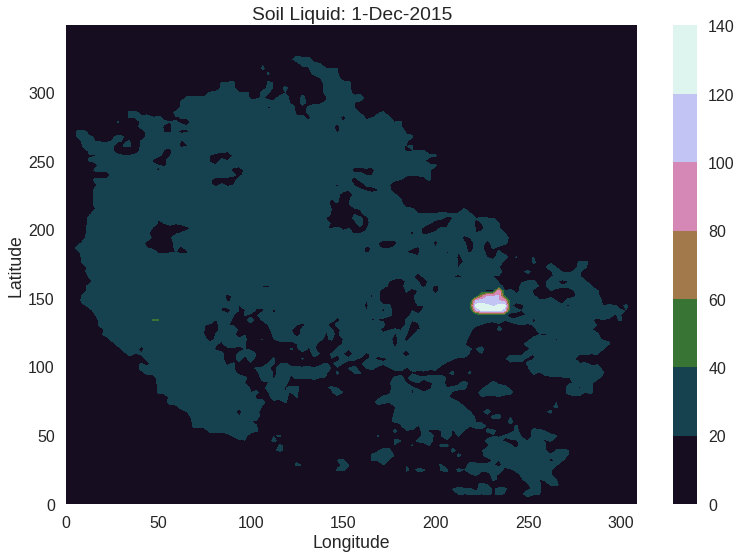

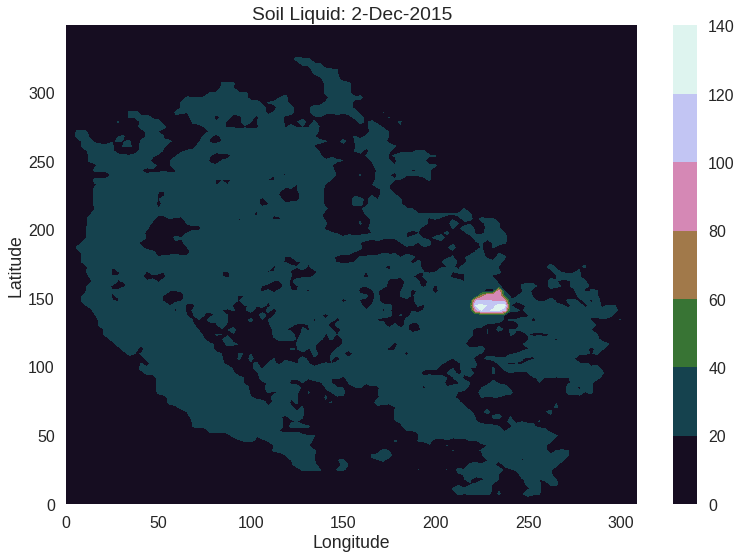

Soil_Liquid_1.png


'/home2/svimal/Github/UCLA-Hydro/MRPI/JupyterNotebooks'

In [353]:
# Create the interpolated surface of the VIC variables for each lat and lon and Z (soil layer example)
month, year = "Dec", "2015"
filenames = []
for i in range(len(data_lists)):
    day = str(i+1) + ""
    z = data_lists[i]
    x = lons
    y = lats
    X, Y, Z = grid(x, y, z)
    plt.figure(i)
    plt.contourf(X, Y, Z)
    plt.colorbar()
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Soil Liquid: " + str(day) + "-" + str(month) + "-" + str(year))
    #fname = "swe_" + str(i) + ".png"
    fname = "Soil_Liquid_" + str(i) + ".png"
    plt.savefig(fname)
    filenames.append(fname)
    plt.show()
else:
    pass
print(fname)
os.getcwd()

# Creating GeoTIFFs and .ASCII files

In [387]:
def write_asc(fname, data_list, filename):
    
    """
    input: netCDF file, and list containing the x,y,z data, and filename
    output: filename
    creates an asc raster file and clips it to california size
    """
    data =  netCDF4.Dataset(fname, "r")
    
    ncols = len(data.variables["lon"][:])
    nrows = len(data.variables["lat"][:])
    xllcorner = float(min(data.variables["lon"][:])) + (-0.0625/2.0)
    yllcorner = float(min(data.variables["lat"][:])) + (-0.0625/2.0)
    cell_size =  abs(data.variables["lat"][1] - data.variables["lat"][0])
    #nodata_value = -9999
    myArray = np.reshape(data_list, (nrows, ncols))

    with open(filename, "w") as f:
        f.write("NCOLS " + str(ncols) + "\n")
        f.write("NROWS " + str(nrows) + "\n")
        f.write("XLLCORNER " + str(xllcorner) + "\n") 
        f.write("YLLCORNER " + str(yllcorner) + "\n")
        f.write("CELLSIZE " + str(cell_size) + "\n")
        f.write("NODATA_VALUE = -9999\n")
        data_2d =  np.reshape(data_list, (nrows, ncols))
        for line in data_2d:
            f.write(str(list(line)).strip("[").strip("]")[1:].strip("\n") + "\n")
    return filename

In [388]:
fname

'/home2/svimal/Data/VIC_Fluxes/1920s/fluxes.1920-12.nc'

In [ ]:
f = "/home2/svimal/Github/UCLA-Hydro/MRPI/JupyterNotebooks/sm.asc"
os.chdir("/home2/svimal/Github/UCLA-Hydro/MRPI/JupyterNotebooks/")
#os.system('gdal_translate -of "GTiff" sm.asc sm.tif')
#os.system("gdalinfo sm.tif") # https://gis.stackexchange.com/questions/65998/how-can-i-use-gdal-to-batch-define-a-projection
# Assign projection
#os.system("gdalwarp -t_srs EPSG:4326 -te -124.8437500 31.1562500 -105.4687500 53.0312500 sm.tif sm_wgs84.tif")
os.system("gdalwarp -t_srs EPSG:4326 -te -124.8437500 31.1562500 -105.4687500 53.0312500 sm.asc sm_wgs84.tif")
# Clip to boundary
#os.system("gdalwarp -cutline /home2/svimal/Github/CA_drought/data/Spatial/CA_counties/CA_counties_WGS.shp -crop_to_cutline -dstalpha sm_wgs84.tif sm_clipped.tif")
os.system("gdalwarp -cutline /home2/svimal/Github/CA_drought/data/Spatial/CA_counties/CA_counties_WGS.shp -crop_to_cutline -dstalpha sm_wgs84.tif sm_clipped_2.tif")

In [356]:
# Create a GIF from the different time steps of the VIC I/O variables
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
# Create GIF files from the snow water equivalent
#imageio.mimsave('SWE_GIF.gif', images, duration=0.5)
imageio.mimsave('Soil_Liquid_GIF.gif', images, duration=0.5)
os.getcwd()

'/home2/svimal/Github/UCLA-Hydro/MRPI/JupyterNotebooks'

In [357]:
# View the GIF
from IPython.display import Image
Image(url='Soil_Liquid_GIF.gif')

# Working with VIC gridded data (from NetCDF)
## Plot variables "Prec", "Evap", "Runoff", "Baseflow", "Tair", "Soil_liquid", "SWE" 

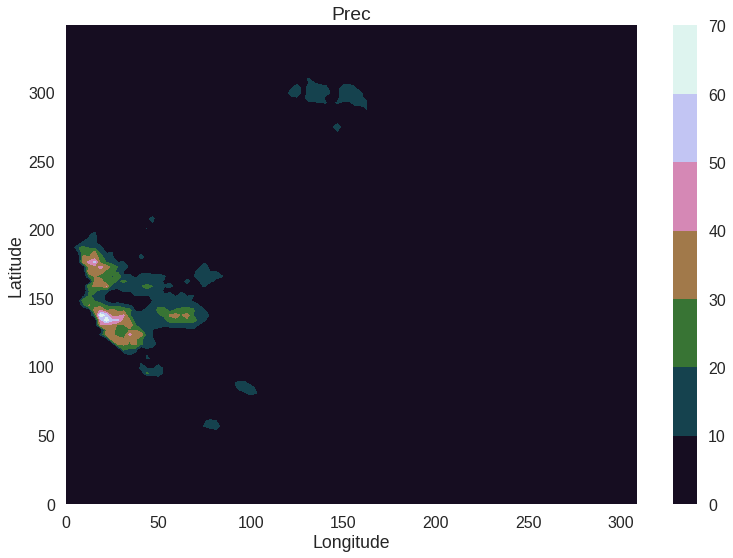

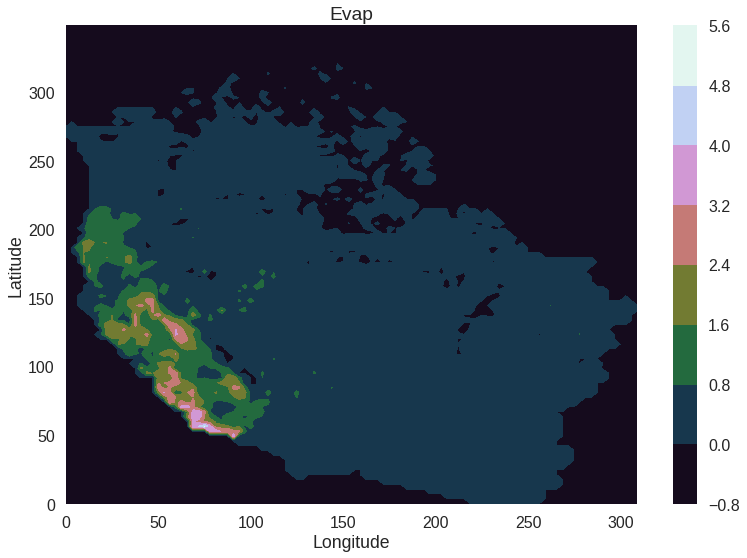

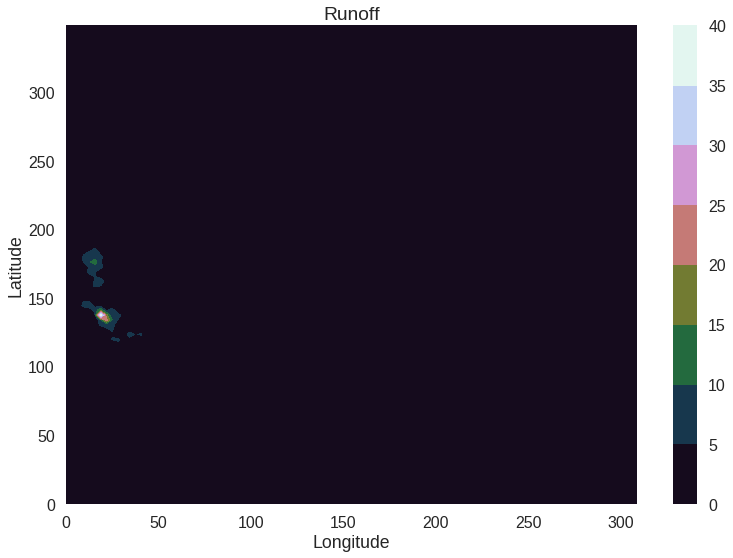

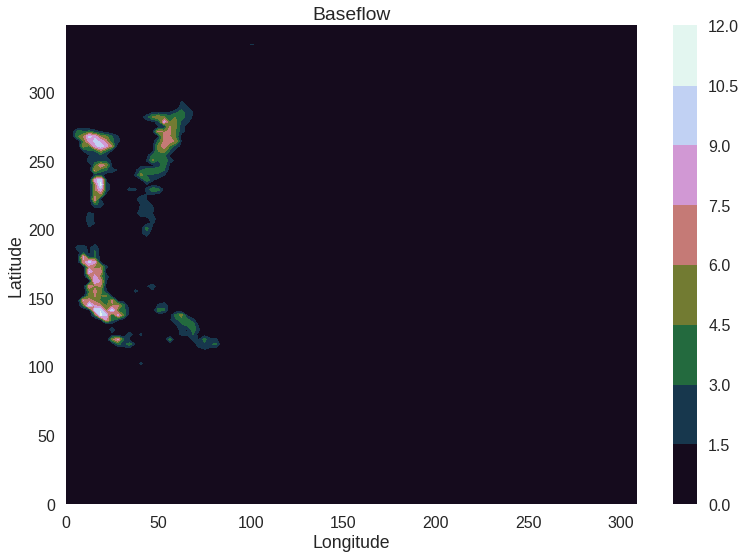

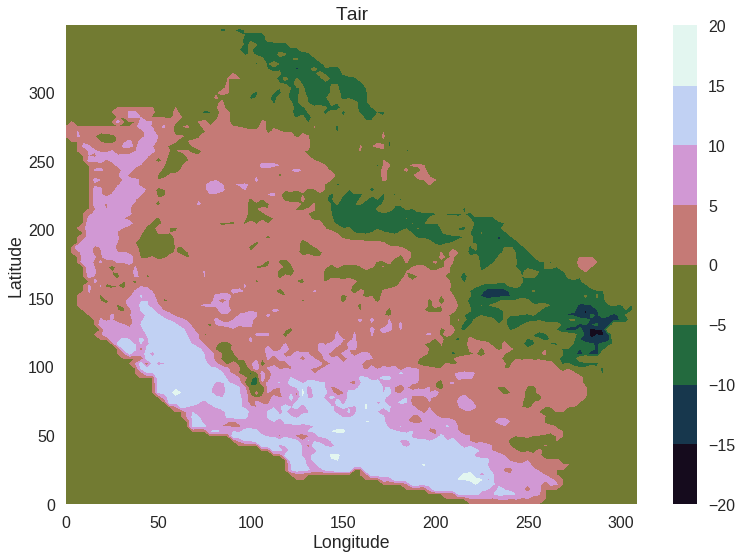

In [360]:
# Other input and uutput fluxes from VIC: Precipitation, Runoff, Baseflow, Air Temperature:

fname = "/home2/svimal/Data/VIC_Fluxes/1920s/fluxes.1920-12.nc"
data = netCDF4.Dataset(fname, "r")

variables = ["Prec", "Evap", "Runoff", "Baseflow", "Tair", "Soil_liquid", "SWE"]
day=1
data_lists = []
filenames=[]

for i, var in enumerate(variables):
    for time in range(len(data["time"][0:1])):
        data_list = []
        if time==0:
            try:
                for lat in range(len(data["lat"][:])):
                    for lon in range(len(data["lon"][:])):
                        d = float(data.variables[var][time][lat][lon])
                        if numpy.isnan(d) == True:
                            data_list.append(0)
                        else:
                            data_list.append(d)
                data_lists.append(data_list)

                z = data_lists[i]
                x = lons
                y = lats
                X, Y, Z = grid(x, y, z)
                plt.figure(i)
                plt.contourf(X, Y, Z)
                plt.colorbar()
                plt.xlabel("Longitude")
                plt.ylabel("Latitude")
                plt.title(str(var))
                #fname = "swe_" + str(i) + ".png"
                #fname = str(var)+ "_" + str(i) + ".png"
                #plt.savefig(fname)
                #filenames.append(fname)
                plt.show()
            except:
                pass
        else:
            pass

# Working with shapefiles

## Dissolve counties - merge the counties to form a single state shapefile

In [409]:

# define your directories and file names
dir_input = '/home2/svimal/Github/CA_drought/data/Spatial/CA_counties/'
name_in = 'CA_counties_WGS.shp'
dir_output = '/home2/svimal/Github/CA_drought/data/Spatial/CA_counties/'
name_out = 'CA.shp'

# create a dictionary
states = {}
# open your file with geopandas
counties = gp.GeoDataFrame.from_file(dir_input + name_in)

for i in range(len(counties)):
    state_id = counties.at[i, 'STATEFP']
    county_geometry = counties.at[i, 'geometry']
    # if the feature's state doesn't yet exist, create it and assign a list
    if state_id not in states:
        states[state_id] = []
    # append the feature to the list of features
    states[state_id].append(county_geometry)

# create a geopandas geodataframe, with columns for state and geometry
states_dissolved = gp.GeoDataFrame(columns=['state', 'geometry'], crs=counties.crs)

# iterate your dictionary
for state, county_list in states.items():
    # create a geoseries from the list of features
    geometry = gp.GeoSeries(county_list)
    # use unary_union to join them, thus returning polygon or multi-polygon
    geometry = geometry.unary_union
    # set your state and geometry values
    states_dissolved.set_value(state, 'state', state)
    states_dissolved.set_value(state, 'geometry', geometry)

# save to file
states_dissolved.to_file(dir_output + name_out, driver="ESRI Shapefile")

# Visualization of vector data on maps

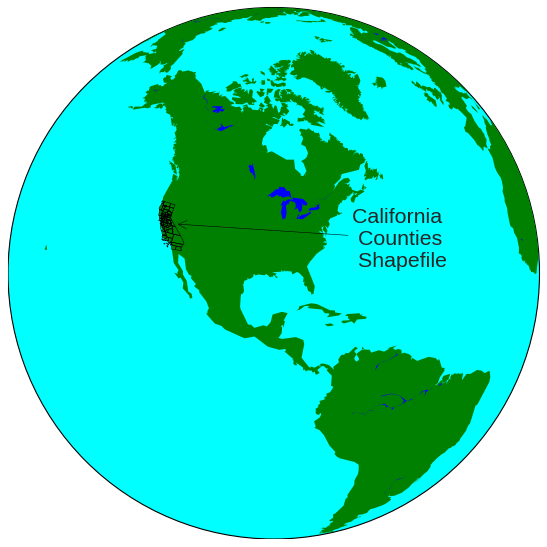

In [18]:
# 3D Globe View
plt.figure(dpi=80)
map = Basemap(projection='ortho', lat_0=30, lon_0=-90)
#llcrnrx=min(data.variables["lon"][:]),llcrnry=min(data.variables["lat"][:]),urcrnrx=max(data.variables["lon"][:]),urcrnry=max(data.variables["lat"][:])

map.drawmapboundary(fill_color='aqua')
map.fillcontinents(color='green',lake_color='blue')
map.readshapefile("/home2/svimal/Github/CA_drought/data/Spatial/CA_counties/CA_counties_WGS", "counties")
#map.drawcoastlines()
x, y = map(-118, 38)
#x2, y2 = (-90, 10)
#plt.annotate('Barcelona', xy=(x, y),  xycoords='data', xytext=(x2, y2), textcoords='offset points',color='r', arrowprops=dict(arrowstyle="fancy", color='g'))
x2, y2 = map(-70, 30)
plt.annotate('California \n Counties \n Shapefile', xy=(x, y),  xycoords='data', xytext=(x2, y2), textcoords='data',
                arrowprops=dict(arrowstyle="->"))
map.contourf(data=Z,x=X, y=Y)
plt.show()

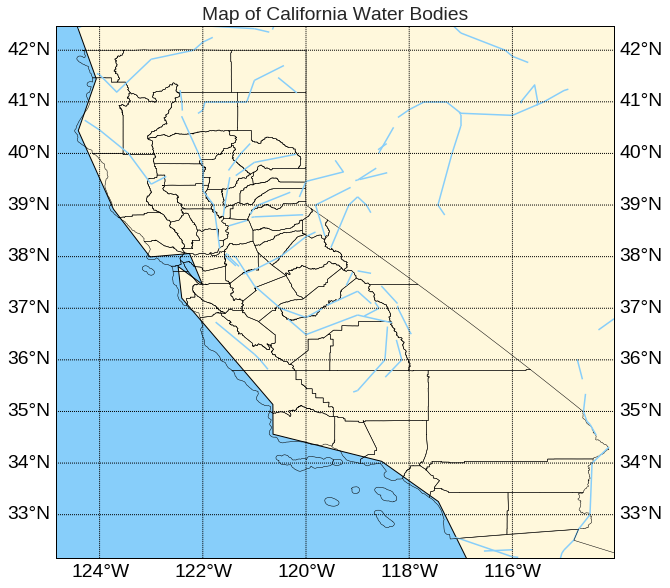

In [412]:
# Water Bodies on the map
# California Water Bodies
water = 'lightskyblue'
earth = 'cornsilk'
juneau_lon, juneau_lat = -124.4167, 38.3
fig, ax1 = plt.subplots(figsize=(10, 10))

mm = Basemap(llcrnrlon=min(data.variables["lon"][:]), llcrnrlat=min(data.variables["lat"][:])+1, 
              urcrnrlon=max(data.variables["lon"][:])-8.5, urcrnrlat=max(data.variables["lat"][:])-10.5)

shp_info = mm.readshapefile(shp1[:-4],'Counties',drawbounds=True)

coast = mm.drawcoastlines()
rivers = mm.drawrivers(color=water, linewidth=1.5)
continents = mm.fillcontinents(color=earth,lake_color=water)
bound= mm.drawmapboundary(fill_color=water)
countries = mm.drawcountries()
merid = mm.drawmeridians(np.arange(-180, 180, 2), labels=[False, False, False, True])
parall = mm.drawparallels(np.arange(0, 80), labels=[True, True, False, False])
#x, y = mm(juneau_lon, juneau_lat)
#juneau = mm.scatter(x, y, 80, label="Juneau", color='red', zorder=10)
plt.title("Map of California Water Bodies")

# Zonal Statistics on VIC gridded data, County-wise

Index([     u'ALAND',     u'AWATER',     u'CBSAFP',    u'CLASSFP',
         u'COUNTYFP',   u'COUNTYNS',      u'CSAFP',   u'FUNCSTAT',
            u'GEOID',   u'INTPTLAT',   u'INTPTLON',       u'LSAD',
         u'METDIVFP',      u'MTFCC',       u'NAME',   u'NAMELSAD',
         u'OBJECTID',    u'STATEFP', u'Shape_Area', u'Shape_Leng',
        u'geoid_num',   u'geometry'],
      dtype='object')


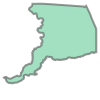

In [51]:
# Open Shapefile
shp = counties
print(shp.columns)

# Look at one of the polygon and shapefile attributes by index
shp.geometry[1]

In [68]:
# View the shapefile attribute table
shp[0:10]

,ALAND,AWATER,CBSAFP,CLASSFP,COUNTYFP,COUNTYNS,CSAFP,FUNCSTAT,GEOID,INTPTLAT,...,METDIVFP,MTFCC,NAME,NAMELSAD,OBJECTID,STATEFP,Shape_Area,Shape_Leng,geoid_num,geometry
0,2.468695e+09,2.329911e+07,,H1,091,00277310,,A,06091,+39.5769252,...,,G4020,Sierra,Sierra County,1,06,2.491994e+09,289385.614942,6091,POLYGON ((-120.6555850002828 39.69356000019291...
1,2.499184e+09,7.607383e+07,40900,H1,067,00277298,472,A,06067,+38.4500114,...,,G4020,Sacramento,Sacramento County,2,06,2.575258e+09,318185.814093,6067,POLYGON ((-121.1885710003181 38.71430800032146...
2,7.084001e+09,2.729815e+09,42200,H1,083,00277306,,A,06083,+34.5370572,...,,G4020,Santa Barbara,Santa Barbara County,3,06,9.813816e+09,735081.464700,6083,(POLYGON ((-120.5818970000262 34.0985570000792...
3,2.641821e+09,4.380603e+07,,H1,009,01675885,,A,06009,+38.1838996,...,,G4020,Calaveras,Calaveras County,4,06,2.685627e+09,288104.640870,6009,POLYGON ((-120.6309329997901 38.34109999974949...
4,4.773390e+09,9.459428e+08,37100,H1,111,00277320,348,A,06111,+34.3587415,...,,G4020,Ventura,Ventura County,5,06,5.719333e+09,435878.206394,6111,(POLYGON ((-119.6363019999335 33.2730399996247...
5,1.051065e+10,1.794730e+09,31080,H1,037,00277283,348,A,06037,+34.1963983,...,31084,G4020,Los Angeles,Los Angeles County,6,06,1.230538e+10,732228.231744,6037,(POLYGON ((-118.6676019997802 33.4774889995503...
6,4.081438e+09,4.975088e+08,42220,H1,097,01657246,488,A,06097,+38.5251824,...,,G4020,Sonoma,Sonoma County,7,06,4.578947e+09,380528.146906,6097,POLYGON ((-122.9350600003598 38.31395200034622...
7,3.598583e+09,5.468555e+06,25260,H1,031,00277280,546,A,06031,+36.0724780,...,,G4020,Kings,Kings County,8,06,3.604052e+09,286288.450805,6031,POLYGON ((-119.9589249999656 36.25546799982109...
8,1.089515e+10,8.261950e+08,41740,H1,073,00277301,,A,06073,+33.0236041,...,,G4020,San Diego,San Diego County,9,06,1.172135e+10,463176.286896,6073,POLYGON ((-117.4374260002855 33.17952999992508...
9,3.644333e+09,2.464869e+08,40900,H1,061,00277295,472,A,06061,+39.0620323,...,,G4020,Placer,Placer County,10,06,3.890820e+09,413958.597744,6061,"POLYGON ((-121.065436000296 39.00653300018334,..."


# Plots
Plots of min-median-max statistics for all Counties

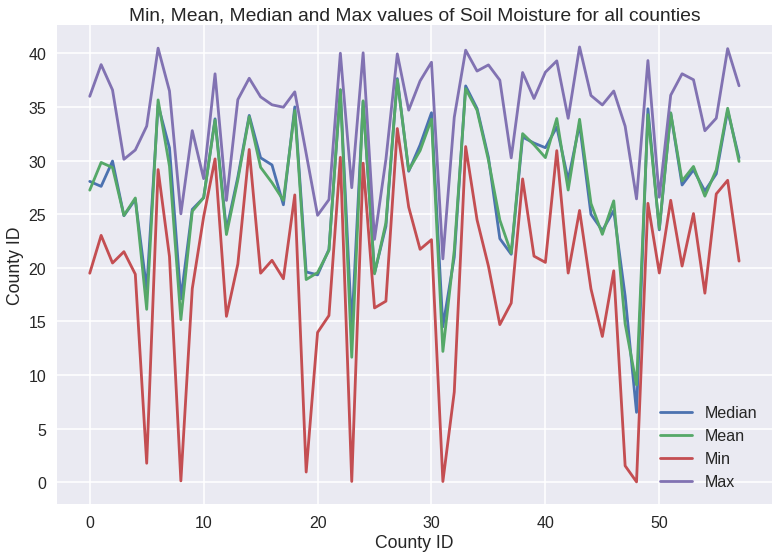

In [378]:
# Raster Stats from the county shapefiles and the Soil Moisture Layer
shp1 = '/home2/svimal/Github/CA_drought/data/Spatial/CA_counties/CA_counties_WGS.shp'
ras = '/home2/svimal/Github/UCLA-Hydro/MRPI/JupyterNotebooks/sm3.asc'
#ras = '/home2/svimal/Github/UCLA-Hydro/MRPI/Images/sm.asc'

stats = rasterstats.zonal_stats(shp1, ras, stats="min max mean median majority sum")
#print(stats)

# Medians
medians = []
for i in range(len(stats)):
    medians.append(stats[i]["median"])    

plt.ylabel("Median value of Soil Moisture"); plt.xlabel("County ID")
plt.plot(medians, label="Median")
    
# Means
means = []
for i in range(len(stats)):means.append(stats[i]["mean"]) 

plt.ylabel("Mean value of Soil Moisture"); plt.xlabel("County ID")
plt.plot(means, label="Mean")

# Maxs
maxs = []; 
for i in range(len(stats)):maxs.append(stats[i]["max"])
    
# Mins
mins = []
for i in range(len(stats)):mins.append(stats[i]["min"])
plt.plot(mins, label="Min")    

# Plot properties
plt.title("Min, Mean, Median and Max values of Soil Moisture for all counties"); plt.ylabel("County ID")
plt.plot(maxs, label="Max")
plt.legend()

# Attributes of the Shapefile

In [381]:
# List of Properties of the shapefile that can be queried

len(medians)
shp["NAME"][i]

# Searching for attributes
for i in range(len(shp)):
    if shp.NAME[i] == "Sacramento":
        print("found it!")


# Dictionary of the medians of soil moisture value in each county
medians_dict = {}
for i in range(len(shp)):
    medians_dict[str(shp["NAME"][i])] = medians[i]

found it!


# List of Counties

In [62]:
# Dictionary of Counties and their corresponding median values
print(medians_dict)

{'Stanislaus': 22.002899169921875, 'Shasta': 23.81329917907715, 'Lake': 34.463199615478516, 'Imperial': 30.906150817871094, 'Orange': 25.012300491333008, 'Madera': 15.391599655151367, 'Plumas': 20.394851684570312, 'Tuolumne': 16.885650634765625, 'Napa': 27.768949508666992, 'Tulare': 22.537500381469727, 'Sierra': 25.370349884033203, 'San Francisco': 24.409198760986328, 'Riverside': 27.65019989013672, 'Alameda': 19.78529930114746, 'Colusa': 31.83300018310547, 'Trinity': 29.783199310302734, 'Santa Clara': 22.037200927734375, 'Solano': 22.397300720214844, 'Sacramento': 19.628000259399414, 'San Diego': 27.80994987487793, 'San Mateo': 23.005550384521484, 'Marin': 27.555099487304688, 'Santa Cruz': 26.882099151611328, 'Glenn': 32.540199279785156, 'Amador': 12.937000274658203, 'Los Angeles': 27.06705093383789, 'Modoc': 21.52560043334961, 'Lassen': 20.97909927368164, 'Butte': 18.274700164794922, 'Nevada': 28.007600784301758, 'Mendocino': 32.16324996948242, 'Mariposa': 17.744699478149414, 'Siskiy

# Zonal Statistics plotted on map

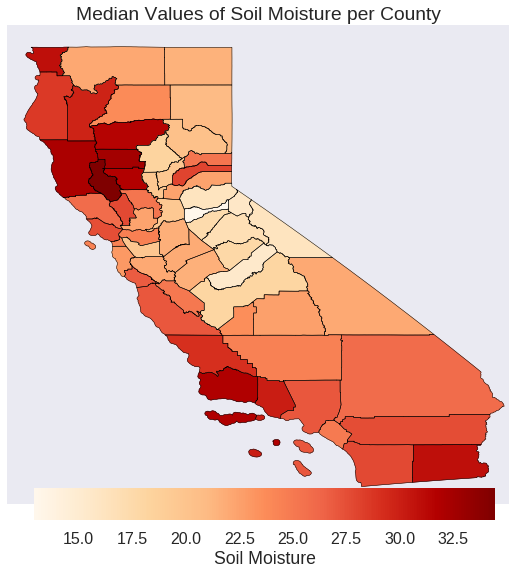

In [65]:
# Map of median values of soil moisture by counties
m = Basemap(llcrnrlon=min(data.variables["lon"][:]), llcrnrlat=min(data.variables["lat"][:])+1, 
              urcrnrlon=max(data.variables["lon"][:])-8.5, urcrnrlat=max(data.variables["lat"][:])-10.5)

ax = plt.gca() 
fig = plt.gcf()
shp_info = m.readshapefile(shp1[:-4],'Counties',drawbounds=True)

nodata_color = "darkorange"
colors={}
County_names=[]
patches = []

cmap = plt.cm.OrRd #binary, summer https://matplotlib.org/users/colormaps.html 
vmin = min(medians); vmax = max(medians)
norm = Normalize(vmin=vmin, vmax=vmax)

# color mapper to covert values to colors
mapper = ScalarMappable(norm=norm, cmap=cmap)

for shapedict in m.Counties_info:
    County_name = shapedict['NAMELSAD']
    County_name = County_name[:-7]
    if County_name in medians_dict:
        value = medians_dict[County_name]
        colors[County_name] = mapper.to_rgba(value)
        County_names.append(County_name)
    else:
        County_names.append(County_name)
        colors[County_name] = nodata_color

for nshape,seg in enumerate(m.Counties):
    color = rgb2hex(colors[County_names[nshape]]) 
    poly = Polygon(seg,facecolor=color,edgecolor=color)
    if (colors[County_names[nshape]] == nodata_color):
        p_no = poly
    ax.add_patch(poly)
    
plt.title('Median Values of Soil Moisture per County')

# put legend for no data states
#if p_no is not None:
#    plt.legend((p_no,), ('No data',))

# construct custom colorbar
cax = fig.add_axes([0.27, 0.1, 0.5, 0.05]) # posititon
cb = ColorbarBase(cax,cmap=cmap,norm=norm, orientation='horizontal')
cb.ax.set_xlabel('Soil Moisture')
plt.show()

# Subsetting NetCDF (County level) using rasterized Shapefile
The libraries geopandas, rasterio and xarray together are used to rasterize the shapefile and then use that as a mask to perform arithmetic operations on the NetCDF data slices

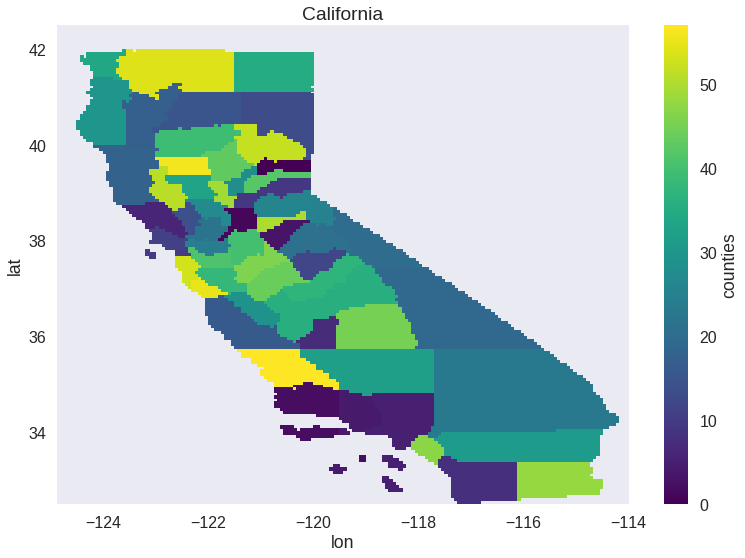

All time steps in a month for Orange County


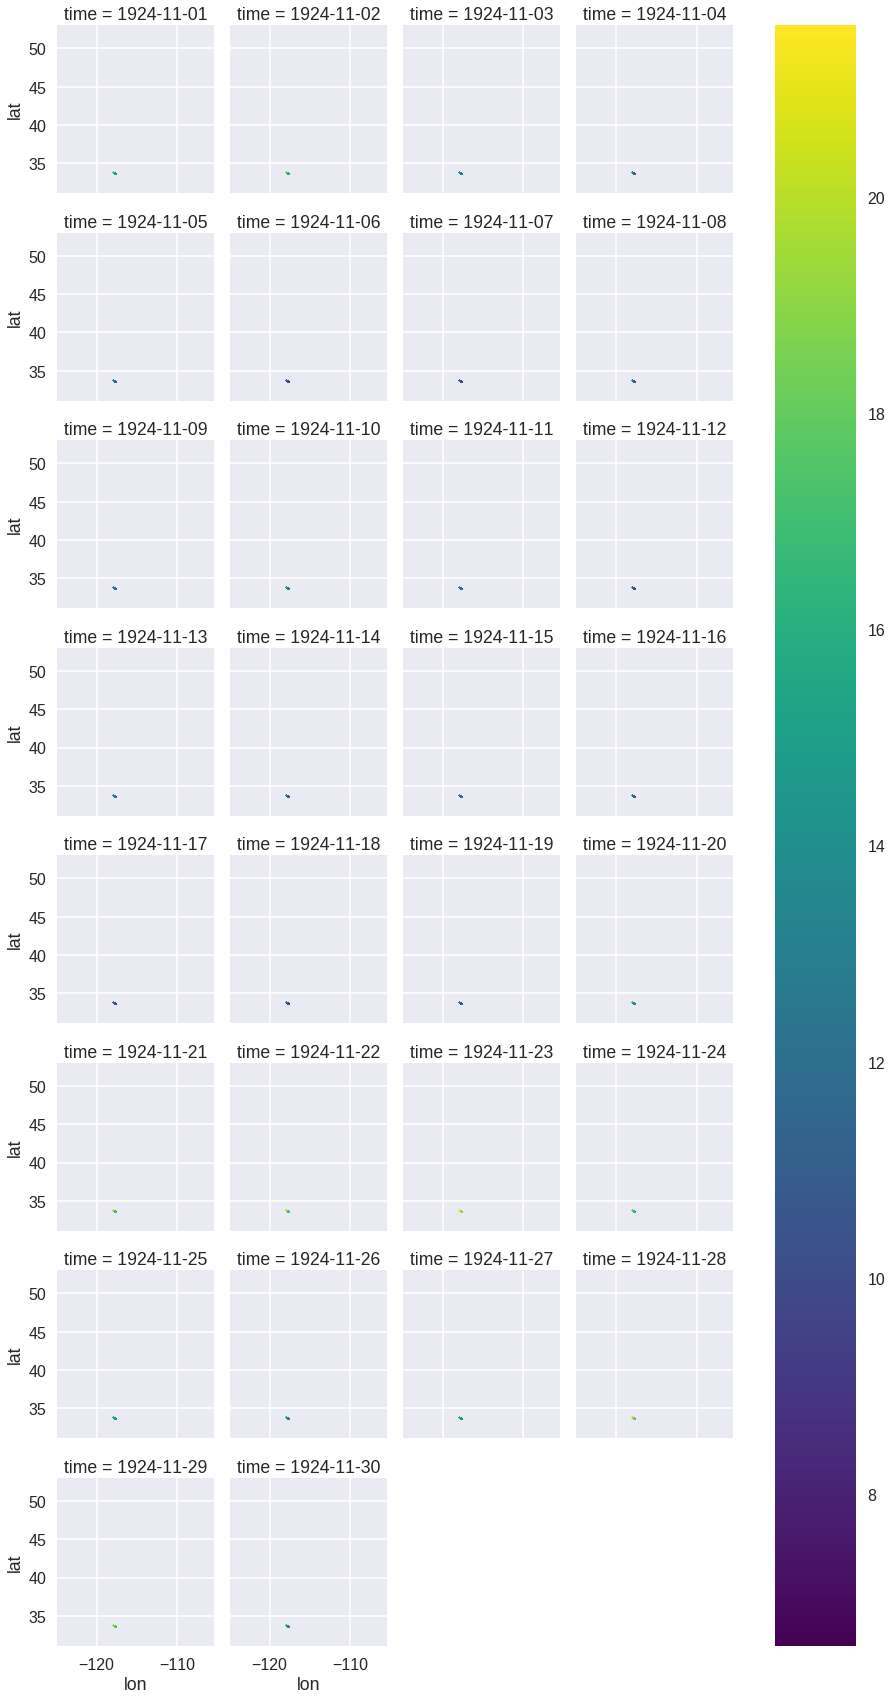

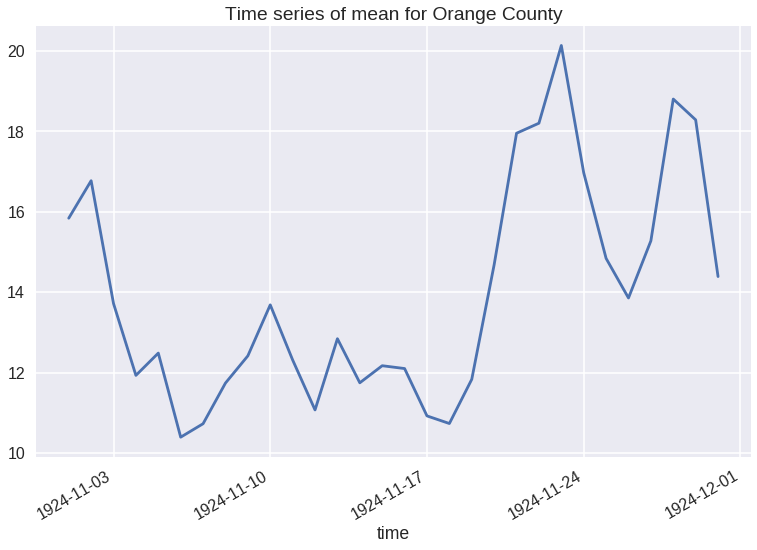

ValueError: dimensions or multi-index levels ['lat', 'lon'] do not exist

In [750]:
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude='latitude', longitude='longitude',
              fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xray.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

# this shapefile is from natural earth data
# http://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/

counties = geopandas.read_file("/home2/svimal/Github/CA_drought/data/Spatial/CA_counties/CA_counties_WGS.shp")
county_ids = {k: i for i, k in enumerate(counties.NAME)}
shapes = zip(counties.geometry, range(len(counties)))
ds = data = xray.open_dataset("/home2/svimal/Data/VIC_Fluxes/1920s/fluxes.1924-11.nc") 
# xray.open_mfdataset("/home2/svimal/Data/VIC_Fluxes/1920s/fluxes.????-??.nc") #
ds["counties"] = rasterize(shapes, ds.coords, longitude="lon", latitude="lat")

# Plot of all counties
(ds.counties.sel(lat=slice(32.5, 42.5), lon=slice(-125.2, -114.0)).plot())
plt.title("California")
plt.show()

print("All time steps in a month for Orange County")

# Make plots
(ds.Tair
 #.isel(time=slice(30))
 .where(ds.counties == county_ids['Orange'])
 #.sel(lat=slice(33.4, 34.0), lon=slice(-118.2, -117.4))
 .plot.imshow(col='time', col_wrap=4))
plt.title("All time steps in a month for Orange County")
plt.show()

# Plot of time series 
(ds.Tair
 #.isel(time=slice(30))
 .where(ds.counties == county_ids['Orange'])
 .sel(lat=slice(32, 43), lon=slice(-122, -112))
 .mean(['lat', 'lon'])
 .plot())
plt.title("Time series of mean for Orange County")
plt.show()

series = (ds.Tair
 #.isel(time=slice(30))
 .where(ds.counties == county_ids['Orange'])
 .mean(['lat', 'lon'])).sel(lat=slice(32, 43), lon=slice(-122, -112))


In [748]:
(ds.Tair.where(ds.counties == county_ids['Sonoma']).mean(['lat', 'lon']))

<xarray.DataArray (time: 31)>
array([ 10.232919,   8.028603,   7.489046,   6.421074,   5.400086,   5.337803,
         7.442049,   8.305243,   8.045563,   8.963831,   8.193525,   3.519019,
         4.713094,   7.200483,   6.359806,   8.31402 ,   8.097842,   8.598185,
         7.848962,   6.472927,   5.057084,   6.397083,   7.285628,   8.433956,
         6.933799,   7.189569,   4.766053,   8.457182,  10.268028,   9.238217,
         8.735235])
Coordinates:
  * time     (time) datetime64[ns] 1920-12-01 1920-12-02 1920-12-03 ...

# GDAL command line operations (file conversions, setting projection, etc.)
Other useful command line operations that were/would be done using these datasets

In [334]:
# Use GDAL functions to convert .asc to .tif, set projection, clip raster with polygon

f = "/home2/svimal/Github/UCLA-Hydro/MRPI/JupyterNotebooks/sm.asc"
os.chdir("/home2/svimal/Github/UCLA-Hydro/MRPI/JupyterNotebooks/")
#os.system('gdal_translate -of "GTiff" sm.asc sm.tif')
#os.system("gdalinfo sm.tif") # https://gis.stackexchange.com/questions/65998/how-can-i-use-gdal-to-batch-define-a-projection
# Assign projection
#os.system("gdalwarp -t_srs EPSG:4326 -te -124.8437500 31.1562500 -105.4687500 53.0312500 sm.tif sm_wgs84.tif")
os.system("gdalwarp -t_srs EPSG:4326 -te -124.8437500 31.1562500 -105.4687500 53.0312500 sm.asc sm_wgs84.tif")
# Clip to boundary
#os.system("gdalwarp -cutline /home2/svimal/Github/CA_drought/data/Spatial/CA_counties/CA_counties_WGS.shp -crop_to_cutline -dstalpha sm_wgs84.tif sm_clipped.tif")
os.system("gdalwarp -cutline /home2/svimal/Github/CA_drought/data/Spatial/CA_counties/CA_counties_WGS.shp -crop_to_cutline -dstalpha sm_wgs84.tif sm_clipped_2.tif")

256

In [746]:
# Data aggregation

# Path to folders 
forcings = glob.glob("/home2/svimal/Data/VIC_Forcing/*/*.nc") # 2 datasets because its divided into cali1 and cali2
fluxes = glob.glob("/home2/svimal/Data/VIC_Fluxes/*/*.nc") # Monthly for 86 years

# No. of files each
len(forcings), len(fluxes) # Forcing files are stored as two parts for california

# Start with fluxes

# Select all the files of one year and work on that. 
years_sorted=[]
for year in range(1920,2015+1):
    #print(year)
    for flux_file in fluxes:
        year_c = str(flux_file.split(".")[1].split("-")[0])
        #print(year_c)
        if str(year)==year_c:
            years_sorted.append(flux_file)

year1 = years_sorted[0:12]
year1_sorted = sorted(year1, key=lambda x: x.split(".")[1].split("-")[1])

counties = geopandas.read_file("/home2/svimal/Github/CA_drought/data/Spatial/CA_counties/CA_counties_WGS.shp")
county_ids = {k: i for i, k in enumerate(counties.NAME)}
shapes = zip(counties.geometry, range(len(counties)))

for fname in year1_sorted:
    #data = netCDF4.Dataset(fname, "r")
    ds = data = xray.open_dataset(fname) 
    # xray.open_mfdataset("/home2/svimal/Data/VIC_Fluxes/1920s/fluxes.????-??.nc") #
    ds["counties"] = rasterize(shapes, ds.coords, longitude="lon", latitude="lat")
    #print(ds)
    ds.time

In [744]:
# Leap year values are in total 18 in the time period - can this be correct?
df = pd.DataFrame.from_dict(data, orient='index')
for i in range(df.shape[0]):
    if numpy.isnan(float(df.sort_index().T.iloc[[53], [i]].as_matrix())):
        pass
    else:
        print(float(df.sort_index().T.iloc[[53], [i]].as_matrix()))

0.0648866670827
0.386773334278
0.0
0.0
0.0
12.4462155236
0.0644311113904
0.00319111112913
0.0
0.0
0.0
11.7686955558
0.390202222102
0.828997786178
0.0
0.0
0.0
10.125855573


In [ ]:
    index = range(len(ds.time))
    stacked = vincent.StackedArea(data, iter_idx='index')
    stacked.axis_titles(x='Days', y='Mean Value of Variable')
    stacked.legend(title='Flux Variables')
    stacked.colors(brew='Spectral')
    stacked

# Format of output
We want something like one file for each week (1-53) for each year (1920-2015) which has the format:

File name will be, e.g. 2015_week1.csv (following Karina's format in /Github/CA_drought/data/processed_data/caseCounts_westnile/weekly/2015/)

So the hydrology fluxes dataset would be (for means): 

County, Precipitation, Evaporation, Surface Runoff, Baseflow, Air Temperature, Soil Liquid (layers), Snow Water Equivalent

Alameda,0,0,0,0,0,0,0 

Butte,0,0,0,0,0,0,0

Calaveras,0,0,0,0,0,0,0

A similar file will be made for max, min, median as well

## Additional variables to be added 

* Surface incident shortwave radiation
* Surface incident longwave radiation
* Near surface air temperature
* Near surface specific humidity
* Surface air pressure
* Rainfall rate
* Snowfall rate
* Near surface wind speed

## Interactive plot visualization 
### TO DO: Make mean-standard deviation plots for each county and link it to the map for interactive visualization 

In [670]:
ds = ds.resample("W", "time", how="mean")
variables = ["Prec", "Evap", "Runoff", "Baseflow", "Tair", "SWE"]
index = range(len(ds.time))
data = {'index': index}
for v in variables:
    series = eval("(ds." + v + ".where(ds.counties == county_ids['Orange']).mean(['lat', 'lon']))")
    #.isel(time=slice(30))#.sel(lat=slice(32, 43), lon=slice(-122, -112)).
    series = list(np.array(series))
    data[v] = series
stacked = vincent.StackedArea(data, iter_idx='index')
stacked.axis_titles(x='Days', y='Mean Value of Variable')
stacked.legend(title='Flux Variables')
stacked.colors(brew='Spectral')
stacked

In [476]:
def getXY(pt):
    return (pt.x, pt.y)
centroidseries = counties['geometry'].centroid

In [755]:
series = (ds.Tair.isel(time=slice(30)).where(ds.counties == county_ids['Orange'])
          #.sel(lat=slice(32, 43), lon=slice(-122, -112))
          .mean(['lat', 'lon']))
buoy_map = folium.Map(location=[33.6835811,-117.9551712,10.5], zoom_start=5,tiles='Stamen Terrain')

for i, name in enumerate(counties["NAME"]):
    centroid = centroidseries[i]
    variables = ["Prec", "Evap", "Runoff", "Baseflow", "Tair", "SWE"]
    index = range(1,31)
    data = {'index': index}
    for v in variables:
        series = eval('(ds.' + v + '.isel(time=slice(30)).where(ds.counties == county_ids["' + name + '"]).mean(["lat", "lon"]))')
        # .sel(lat=slice(32, 43), lon=slice(-122, -112))
        series = list(np.array(series))
        data[v] = series
    stacked = vincent.StackedArea(data, iter_idx='index', width=400, height=250)
    stacked.axis_titles(x='Days', y='Mean Value of Variable')
    stacked.legend(title='Flux Variables for '+name + ' County')
    stacked.colors(brew='Spectral')
    stacked.to_json("vis" + str(i) + ".json")
    """
    series = (ds.Tair.isel(time=slice(30)).where(ds.counties == county_ids[name])
          .sel(lat=slice(32, 43), lon=slice(-122, -112)).mean(['lat', 'lon']))
    plot_data = list(np.array(series))
    #print(i, name, centroid)
    #print(list(centroid.xy)[0][0] , list(centroid.xy)[1][0])
    vis1 = vincent.Line(plot_data, width=400, height=250)
    vis1.axis_titles(x='Day', y='Mean Values')
    vis1.legend(title=name)
    vis1.to_json("vis" + str(i) + ".json")
    """
    popup1 = folium.Popup(max_width=600).add_child(folium.Vega(json.load(open("vis" + str(i) + ".json")), width=600, height=300))
    folium.Marker([list(centroid.xy)[1][0], list(centroid.xy)[0][0]], popup=popup1).add_to(buoy_map)
buoy_map 

In [597]:
interactive_map = buoy_map 
interactive_map.save('interactive_map2.html')